# Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 (OPTIONAL) Improve the WER with Language Models](#part4_info)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [1]:
import numpy as np
import pandas as pd
from asl_data import AslDb


asl = AslDb() # initializes the database
asl.df.head() # displays the first five rows of the asl database, indexed by video and frame

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [2]:
asl.df.ix[98,1]  # look at the data available for an individual frame

left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [2]:
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df.head()  # the new feature 'grnd-ry' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  
video frame           
98    0          113  
      1          113  
      2          113  
      3          113  
      4          113

##### Try it!

In [3]:
from asl_utils import test_features_tryit
# add df columns for 'grnd-rx', 'grnd-ly', 'grnd-lx' representing differences between hand and nose locations
asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y']
asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x']
# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  
video frame                                      
98    0          113        9      119      -12  
      1          113        9      119      -12  
      2          113        9      119      -12  
      3          113        9      119      -12  
      4          113        9      119      -12

In [4]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
 #show a single set of features for a given (video, frame) tuple
[asl.df.ix[98,1][v] for v in features_ground]

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [5]:
training = asl.build_training(features_ground)
print("Training words: {}".format(training.words))

Training words: ['JOHN', 'WRITE', 'HOMEWORK', 'IX-1P', 'SEE', 'YESTERDAY', 'IX', 'LOVE', 'MARY', 'CAN', 'GO', 'GO1', 'FUTURE', 'GO2', 'PARTY', 'FUTURE1', 'HIT', 'BLAME', 'FRED', 'FISH', 'WONT', 'EAT', 'BUT', 'CHICKEN', 'VEGETABLE', 'CHINA', 'PEOPLE', 'PREFER', 'BROCCOLI', 'LIKE', 'LEAVE', 'SAY', 'BUY', 'HOUSE', 'KNOW', 'CORN', 'CORN1', 'THINK', 'NOT', 'PAST', 'LIVE', 'CHICAGO', 'CAR', 'SHOULD', 'DECIDE', 'VISIT', 'MOVIE', 'WANT', 'SELL', 'TOMORROW', 'NEXT-WEEK', 'NEW-YORK', 'LAST-WEEK', 'WILL', 'FINISH', 'ANN', 'READ', 'BOOK', 'CHOCOLATE', 'FIND', 'SOMETHING-ONE', 'POSS', 'BROTHER', 'ARRIVE', 'HERE', 'GIVE', 'MAN', 'NEW', 'COAT', 'WOMAN', 'GIVE1', 'HAVE', 'FRANK', 'BREAK-DOWN', 'SEARCH-FOR', 'WHO', 'WHAT', 'LEG', 'FRIEND', 'CANDY', 'BLUE', 'SUE', 'BUY1', 'STOLEN', 'OLD', 'STUDENT', 'VIDEOTAPE', 'BORROW', 'MOTHER', 'POTATO', 'TELL', 'BILL', 'THROW', 'APPLE', 'NAME', 'SHOOT', 'SAY-1P', 'SELF', 'GROUP', 'JANA', 'TOY1', 'MANY', 'TOY', 'ALL', 'BOY', 'TEACHER', 'GIRL', 'BOX', 'GIVE2', 'GIVE3

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

In [7]:
training.get_word_Xlengths('CHOCOLATE')

(array([[-11,  48,   7, 120],
        [-11,  48,   8, 109],
        [ -8,  49,  11,  98],
        [ -7,  50,   7,  87],
        [ -4,  54,   7,  77],
        [ -4,  54,   6,  69],
        [ -4,  54,   6,  69],
        [-13,  52,   6,  69],
        [-13,  52,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [-10,  59,   7,  71],
        [-15,  64,   9,  77],
        [-17,  75,  13,  81],
        [ -4,  48,  -4, 113],
        [ -2,  53,  -4, 113],
        [ -4,  55,   2,  98],
        [ -4,  58,   2,  98],
        [ -1,  59,   2,  89],
        [ -1,  59,  -1,  84],
        [ -1,  59,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ 

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [6]:
df_means = asl.df.groupby('speaker').mean()
df_means

left-x      left-y     right-x     right-y      nose-x  \
speaker                                                               
man-1    206.248203  218.679449  155.464350  150.371031  175.031756   
woman-1  164.661438  161.271242  151.017865  117.332462  162.655120   
woman-2  183.214509  176.527232  156.866295  119.835714  170.318973   

            nose-y    grnd-ry    grnd-rx     grnd-ly    grnd-lx  
speaker                                                          
man-1    61.642600  88.728430 -19.567406  157.036848  31.216447  
woman-1  57.245098  60.087364 -11.637255  104.026144   2.006318  
woman-2  58.022098  61.813616 -13.452679  118.505134  12.895536

To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [7]:
asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x'])
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  left-x-mean  
video frame                                                   
98    0          113        9      119      -12   164.661438  
      1          113        9      119      -12   164.661438  
      2          113        9      119      -12   164.661438  
      3          113        9      119      -12   164.661438  
      4          113        9      119      -12   164.661438

##### Try it!

In [8]:
from asl_utils import test_std_tryit
# Create a dataframe named `df_std` with standard deviations grouped by speaker
df_std = asl.df.groupby('speaker').std()
# test the code
test_std_tryit(df_std)

df_std


left-x     left-y    right-x    right-y    nose-x    nose-y  \
speaker                                                                   
man-1    15.154425  36.328485  18.901917  54.902340  6.654573  5.520045   
woman-1  17.573442  26.594521  16.459943  34.667787  3.549392  3.538330   
woman-2  15.388711  28.825025  14.890288  39.649111  4.099760  3.416167   

           grnd-ry    grnd-rx    grnd-ly    grnd-lx  left-x-mean  
speaker                                                           
man-1    53.487999  20.269032  36.572749  15.080360          0.0  
woman-1  33.972660  16.764706  27.117393  17.328941          0.0  
woman-2  39.128572  16.191324  29.320655  15.050938          0.0

<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.

- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [9]:
# add features for normalized by speaker values of left, right, x, y
# Name these 'norm-rx', 'norm-ry', 'norm-lx', and 'norm-ly'
# using Z-score scaling (X-Xmean)/Xstd
def z_score(col):
    Xmean = asl.df['speaker'].map(df_means[col])
    Xstd = asl.df['speaker'].map(df_std[col])
    return (asl.df[col]-Xmean)/Xstd
#  x: array([-0.891,  0.742,  1.153,  1.663])
#  y: array([ 1.153,  1.663, -0.891,  0.742])
cols = ['right-x','right-y','left-x','left-y']
features_norm = ['norm-rx', 'norm-ry', 'norm-lx','norm-ly']
for f_norm, col in zip(features_norm, cols):
    asl.df[f_norm] = z_score(col)
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  left-x-mean   norm-rx  \
video frame                                                              
98    0          113        9      119      -12   164.661438  1.153232   
      1          113        9      119      -12   164.661438  1.153232   
      2          113        9      119      -12   164.661438  1.153232   
      3          113        9      119      -12   164.661438  1.153232   
      4          113        9      119      -12   164.661438  1.153232   

              norm-ry   norm-lx   norm-ly  
video frame                                
98    0      1.663433 -0.891199  0.741835  
      1      1.663433 -0.891199  0.741835  
      2      1.663433 -0.891199  0.741835  
      3      1.663433 -0.891199  0.741835  
      4      1.663433 -0.891199  0.741835

In [10]:
# add features for polar coordinate values where the nose is the origin
# Name these 'polar-rr', 'polar-rtheta', 'polar-lr', and 'polar-ltheta'
# Note that 'polar-rr' and 'polar-rtheta' refer to the radius and angle
def polar_coords_r(col_x,col_y):
    return np.sqrt(np.square(asl.df[col_x])+np.square(asl.df[col_y]))

def polar_coords_theta(col_x,col_y):
    # ASL often has hand moving to nose-height which would make the angle jump
    # from 0->2Pi very quickly - looking like a large change.
    # arctan2(x,y) used instead of arctan2(y,x) to move 0->2Pi discontinuity
    # above speakers head (ASL doesn't often use that space) to avoid this.
    return np.arctan2(asl.df[col_x], asl.df[col_y])

features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']
asl.df['polar-rr'] = polar_coords_r('grnd-rx','grnd-ry')
asl.df['polar-rtheta'] = polar_coords_theta('grnd-rx','grnd-ry')
asl.df['polar-lr'] = polar_coords_r('grnd-lx','grnd-ly')
asl.df['polar-ltheta'] = polar_coords_theta('grnd-lx','grnd-ly')
asl.df.head()


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  left-x-mean   norm-rx  \
video frame                                                              
98    0          113        9      119      -12   164.661438  1.153232   
      1          113        9      119      -12   164.661438  1.153232   
      2          113        9      119      -12   164.661438  1.153232   
      3          113        9      119      -12   164.661438  1.153232   
      4          113        9      119      -12   164.661438  1.153232   

              norm-ry   norm-lx   norm-ly   polar-rr  polar-rtheta  \
video frame                                                          
98    0      1.663433 -0.891199  0.741835  113.35784      0.079478   
      1      1.663433 -0.891199  0.741835  113.35784      0.079478   
      2      1.663433 -0.891199  0.741835  113.35784      0.079478   
      3      1.663433 -0.891199  0.741835  113.35784      0.079478   
      4      1.663433 -0.891199  0.741835  113.35784      0.079478   

               polar-lr  polar-ltheta  
video frame                            
98    0      119.603512     -0.100501  
      1      119.603512     -0.100501  
      2      119.603512     -0.100501  
      3      119.603512     -0.100501  
      4      119.603512     -0.100501

In [11]:
# add features for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
# Name these 'delta-rx', 'delta-ry', 'delta-lx', and 'delta-ly'

features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']
for f_delta, col in zip(features_delta, cols):
    asl.df[f_delta] = asl.df[col].diff().fillna(0)
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly    ...      norm-lx   norm-ly  \
video frame                               ...                          
98    0          113        9      119    ...    -0.891199  0.741835   
      1          113        9      119    ...    -0.891199  0.741835   
      2          113        9      119    ...    -0.891199  0.741835   
      3          113        9      119    ...    -0.891199  0.741835   
      4          113        9      119    ...    -0.891199  0.741835   

              polar-rr  polar-rtheta    polar-lr  polar-ltheta  delta-rx  \
video frame                                                                
98    0      113.35784      0.079478  119.603512     -0.100501       0.0   
      1      113.35784      0.079478  119.603512     -0.100501       0.0   
      2      113.35784      0.079478  119.603512     -0.100501       0.0   
      3      113.35784      0.079478  119.603512     -0.100501       0.0   
      4      113.35784      0.079478  119.603512     -0.100501       0.0   

             delta-ry  delta-lx  delta-ly  
video frame                                
98    0           0.0       0.0       0.0  
      1           0.0       0.0       0.0  
      2           0.0       0.0       0.0  
      3           0.0       0.0       0.0  
      4           0.0       0.0       0.0  

[5 rows x 24 columns]

In [12]:
# add features of your own design, which may be a combination of the above or something else
# Name these whatever you would like
def scale_feature(orig, min_, max_):
    return (orig - min_) / (max_ - min_)

df_max = asl.df.groupby('speaker').max()
df_min = asl.df.groupby('speaker').min()

features_max = ['polar-rr-max', 'polar-rtheta-max',
                'polar-lr-max', 'polar-ltheta-max']
features_min = ['polar-rr-min', 'polar-rtheta-min',
                'polar-lr-min', 'polar-ltheta-min']
features_max_min = list(zip(features_max, features_min))
polar_rescaled = ['polar-rr-rescaled', 'polar-rtheta-rescaled',
                  'polar-lr-rescaled', 'polar-ltheta-rescaled']
for max_min, f_p, f_r in zip(features_max_min, features_polar, polar_rescaled):
    max_, min_ = max_min
    asl.df[max_] = asl.df['speaker'].map(
        df_max[f_p], na_action=None)
    asl.df[min_] = asl.df['speaker'].map(
        df_min[f_p], na_action=None)

    asl.df[f_r] = scale_feature(asl.df[f_p],
                          asl.df[min_],
                          asl.df[max_])
# copy new features list incase of mutation later on
features_custom = polar_rescaled[:]
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly          ...            \
video frame                                     ...             
98    0          113        9      119          ...             
      1          113        9      119          ...             
      2          113        9      119          ...             
      3          113        9      119          ...             
      4          113        9      119          ...             

             polar-rr-rescaled  polar-rtheta-max  polar-rtheta-min  \
video frame                                                          
98    0               0.894177          1.125495         -2.498092   
      1               0.894177          1.125495         -2.498092   
      2               0.894177          1.125495         -2.498092   
      3               0.894177          1.125495         -2.498092   
      4               0.894177          1.125495         -2.498092   

             polar-rtheta-rescaled  polar-lr-max  polar-lr-min  \
video frame                                                      
98    0                   0.711331     138.75518     35.777088   
      1                   0.711331     138.75518     35.777088   
      2                   0.711331     138.75518     35.777088   
      3                   0.711331     138.75518     35.777088   
      4                   0.711331     138.75518     35.777088   

             polar-lr-rescaled  polar-ltheta-max  polar-ltheta-min  \
video frame                                                          
98    0               0.814022          1.153898         -0.198946   
      1               0.814022          1.153898         -0.198946   
      2               0.814022          1.153898         -0.198946   
      3               0.814022          1.153898         -0.198946   
      4               0.814022          1.153898         -0.198946   

             polar-ltheta-rescaled  
video frame                         
98    0                   0.072769  
      1                   0.072769  
      2                   0.072769  
      3                   0.072769  
      4                   0.072769  

[5 rows x 36 columns]

**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:**
Polar Coordinates using **feature scaling**. The polar coordinate system, is **more invariant to rotations** than the Cartesian equivalent [[1]]. This likely improved its accuracy as natural variations in wrist/arm rotation during signs would effect the likelihood of recognition less. Feature scaling takes into account the possibility for a broad range of values in the raw data. By normalizing, it helps prevent a particular feature with a large range of values from dominating - allowing each feature to contribute proportionally to the final values.
[1]: https://pdfs.semanticscholar.org/4537/d29d56736295c8323af2a23b5e9e6881cb17.pdf
[[1]] ASL Recognition Based on a Coupling Between HMMs and 3D Motion Analysis, Christian Vogler and Dimitris Metaxas

<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [13]:
import unittest
# import numpy as np

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.011s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample sequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [13]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL

demoword = 'BOOK'
model, logL = train_a_word(demoword, 3, features_ground)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for BOOK is 3
logL = -2331.1138127433164


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [14]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for BOOK is 3
hidden state #0
mean =  [ -1.12415027  69.44164191  17.02866283  77.7231196 ]
variance =  [ 19.70434594  16.83041492  30.51552305  11.03678246]

hidden state #1
mean =  [ -3.46504869  50.66686933  14.02391587  52.04731066]
variance =  [ 49.12346305  43.04799144  39.35109609  47.24195772]

hidden state #2
mean =  [ -11.45300909   94.109178     19.03512475  102.2030162 ]
variance =  [  77.403668    203.35441965   26.68898447  156.12444034]



##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [15]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 3, features_polar) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 3
hidden state #0
mean =  [ 56.19235087  -0.16348589  71.60640024   0.0958256 ]
variance =  [  5.16348282e+01   4.22849414e-03   1.74535632e+01   1.18341913e-03]

hidden state #1
mean =  [  8.81313612e+01   8.31771967e-03   1.09304329e+02   1.18434797e-01]
variance =  [  2.06973439e+01   5.41190376e-03   1.41647879e+02   1.92144403e-03]

hidden state #2
mean =  [  6.05010053e+01  -9.31757873e-02   9.14166393e+01   2.57297227e-02]
variance =  [  6.15523307e+01   3.56540651e-03   1.30626433e+02   1.81995354e-03]

logL = -179.21522065553515


##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [16]:
%matplotlib inline

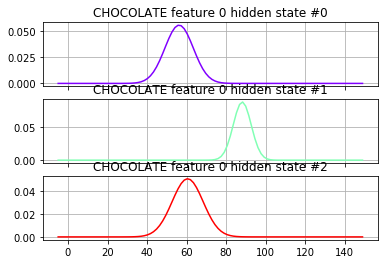

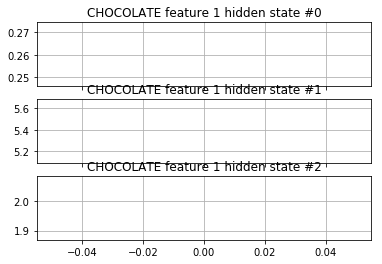

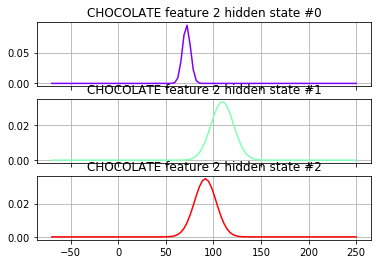

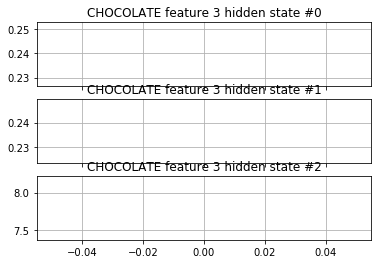

In [17]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
        
visualize(my_testword, model)

#####  ModelSelector class
Review the `ModelSelector` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [15]:
from my_model_selectors import SelectorConstant

training = asl.build_training(features_custom)  # Experiment here with different feature sets defined in part 1
word = 'CHOCOLATE' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for CHOCOLATE is 3


##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [20]:
from sklearn.model_selection import KFold

training = asl.build_training(features_custom) # Experiment here with different feature sets
word = 'VEGETABLE' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

Train fold indices:[2 3 4 5] Test fold indices:[0 1]
Train fold indices:[0 1 4 5] Test fold indices:[2 3]
Train fold indices:[0 1 2 3] Test fold indices:[4 5]


**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [18]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit

In [19]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

In [28]:
from my_model_selectors import SelectorCV

training = asl.build_training(features_custom)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 2 states with time 0.2810655490792833 seconds
Training complete for BOOK with 2 states with time 1.4612566249549674 seconds
Training complete for VEGETABLE with 2 states with time 0.653078685265035 seconds
Training complete for FUTURE with 13 states with time 1.2678674486099824 seconds
Training complete for JOHN with 13 states with time 12.60883693042871 seconds


In [29]:
from my_model_selectors import SelectorBIC

training = asl.build_training(features_custom)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 2 states with time 0.18568320003490157 seconds
Training complete for BOOK with 13 states with time 1.1172356778907684 seconds
Training complete for VEGETABLE with 3 states with time 0.4560776032010878 seconds
Training complete for FUTURE with 13 states with time 1.0904673470441821 seconds
Training complete for JOHN with 14 states with time 10.478303061955462 seconds


In [30]:
from my_model_selectors import SelectorDIC

training = asl.build_training(features_custom)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 2 states with time 1.5278967506322232 seconds
Training complete for BOOK with 13 states with time 2.4859798453158675 seconds
Training complete for VEGETABLE with 3 states with time 1.8513876756348964 seconds
Training complete for FUTURE with 7 states with time 2.473346355741434 seconds
Training complete for JOHN with 14 states with time 11.959998280503179 seconds


**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:**

**CV**:
* Advantages:
    * Avoids overfitting through simulating behaviour for unseen test data
    * Reasonable model accuracy can be obtained using a relatively small amount of data
* Disadvantages:
    * Expensive - computationally and spatially. For each *n*-component model tested, training sequences are split into multiple `train` and `test` folds from which the new *n*-component model must be trained and then tested. Then once a value for *n* is chosen another model must be created and trained on the entire data set.
    * Doesn't take in to account other 'words' in the system - could lead to models for different words producing very similar results.
    
**BIC**:
* Advantages:
    * Avoids overfitting by penalising model complexity
    * Relatively simple to compute (once free parameters are calculated)
* Disadvantages:
    * Requires a large data set - BIC is only valid when the sample size is much greater than the number of parameters in the model 
    -- <cite>[1]</cite>
    * Number of free paramaters *k* (used in calculating BIC) in HMM increases **quadratically** with the number of states.
    * Doesn't take in to account other 'words' in the system - could lead to models for different words producing very similar results.
    
**DIC**:
* Advantages:
    * Takes into account the whole system, reduces similarity between models for different 'words'
    * Higher performance than BIC -- <cite>[[2]]</cite>
* Disadvantages:
    * May lead to overfitting and a large number of parameters as model complexity is not directly considered



[1] Giraud, C. (2015). Introduction to high-dimensional statistics. Chapman & Hall/CRC. ISBN 9781482237948.

[[2]] Biem, Alain. "A model selection criterion for classification: Application to hmm topology optimization."
    Document Analysis and Recognition, 2003. Proceedings. Seventh International Conference on. IEEE, 2003.
[2]: http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf 

<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [31]:
from asl_test_model_selectors import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 24.430s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [20]:
from my_model_selectors import SelectorConstant, SelectorCV, SelectorBIC, SelectorDIC

def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

models = train_all_words(features_ground, SelectorConstant)
print("Number of word models returned = {}".format(len(models)))

Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [22]:
test_set = asl.build_test(features_ground)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [21]:
from my_recognizer import recognize
from asl_utils import show_errors
all_features = {'features_ground':features_ground,'features_norm':features_norm,
                'features_polar':features_polar,'features_delta':features_delta,
                'features_custom':features_custom}
all_model_selectors = {'SelectorConstant':SelectorConstant, 'SelectorCV':SelectorCV, 
                       'SelectorBIC':SelectorBIC, 'SelectorDIC':SelectorDIC}

In [37]:
# Testing all combinations
# Recognize the test set and display the result with the show_errors method

def calc_WER(guesses, test_set, verbose=False):
    """ Modified show_errors to calculate and return WER without detailed breakdown.

    :param guesses: list of test item answers, ordered
    :param test_set: SinglesData object
    :param verbose: If True, will print summary output. Default=False
    :return:
        float: WER
    """
    S = 0
    N = len(test_set.wordlist)
    num_test_words = len(test_set.wordlist)
    if len(guesses) != num_test_words:
        print("Size of guesses must equal number of test words ({})!".format(
            num_test_words))
    for word_id in range(num_test_words):
        if guesses[word_id] != test_set.wordlist[word_id]:
            S += 1
    wer = float(S) / float(N)
    if verbose:
        print("\n**** WER = {}".format(wer))
        print("Total correct: {} out of {}".format(N - S, N))
    return wer

results = []
for features, selector in [(f, ms) for f in all_features for ms in all_model_selectors]:
    models = train_all_words(all_features[features], all_model_selectors[selector])
    test_set = asl.build_test(all_features[features])
    probabilities, guesses = recognize(models, test_set)
    wer = calc_WER(guesses, test_set)
    results.append([features, selector, wer])

df = pd.DataFrame(results, columns=['Features', 'Model Selector', 'WER'])
df

Features    Model Selector       WER
0   features_ground  SelectorConstant  0.668539
1   features_ground        SelectorCV  0.589888
2   features_ground       SelectorBIC  0.561798
3   features_ground       SelectorDIC  0.561798
4     features_norm  SelectorConstant  0.623596
5     features_norm        SelectorCV  0.617978
6     features_norm       SelectorBIC  0.640449
7     features_norm       SelectorDIC  0.640449
8    features_polar  SelectorConstant  0.617978
9    features_polar        SelectorCV  0.584270
10   features_polar       SelectorBIC  0.533708
11   features_polar       SelectorDIC  0.533708
12   features_delta  SelectorConstant  0.640449
13   features_delta        SelectorCV  0.601124
14   features_delta       SelectorBIC  0.629213
15   features_delta       SelectorDIC  0.640449
16  features_custom  SelectorConstant  0.640449
17  features_custom        SelectorCV  0.573034
18  features_custom       SelectorBIC  0.505618
19  features_custom       SelectorDIC  0.511236

In [38]:
# TODO Choose a feature set and model selector
# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(all_features['features_custom'], all_model_selectors['SelectorBIC'])
test_set = asl.build_test(all_features['features_custom'])
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5056179775280899
Total correct: 88 out of 178
Video  Recognized                                                    Correct
    2: JOHN WRITE HOMEWORK                                           JOHN WRITE HOMEWORK
    7: JOHN *NEXT-WEEK GO *TOY                                       JOHN CAN GO CAN
   12: JOHN *HOUSE *GO1 CAN                                          JOHN CAN GO CAN
   21: *ANN FISH WONT *ANN BUT CAN *FUTURE CHICKEN                   JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *ANN *ANN *LOVE *ANN IX                                       JOHN LIKE IX IX IX
   28: *ANN *ANN *ANN *ANN *LOVE                                     JOHN LIKE IX IX IX
   30: JOHN *MARY *MARY *MARY *LIKE                                  JOHN LIKE IX IX IX
   36: MARY VEGETABLE *YESTERDAY *GIVE2 *MARY *LIKE                  MARY VEGETABLE KNOW IX LIKE CORN1
   40: *MARY *VISIT *DECIDE MARY *MARY                               JOHN IX THINK MARY LOVE
   43: JOHN *PAST BUY HOUSE         

In [39]:
# TODO Choose a feature set and model selector
# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(all_features['features_custom'], all_model_selectors['SelectorDIC'])
test_set = asl.build_test(all_features['features_custom'])
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5112359550561798
Total correct: 87 out of 178
Video  Recognized                                                    Correct
    2: JOHN WRITE HOMEWORK                                           JOHN WRITE HOMEWORK
    7: JOHN *NEXT-WEEK *JOHN *TOY                                    JOHN CAN GO CAN
   12: JOHN *HOUSE *GO1 CAN                                          JOHN CAN GO CAN
   21: *ANN FISH WONT *ANN BUT CAN *FUTURE CHICKEN                   JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *ANN *ANN *LOVE *ANN IX                                       JOHN LIKE IX IX IX
   28: *ANN *ANN *ANN *ANN *LOVE                                     JOHN LIKE IX IX IX
   30: JOHN *MARY *MARY *MARY *LIKE                                  JOHN LIKE IX IX IX
   36: MARY VEGETABLE *GIVE *GIVE2 *MARY *LIKE                       MARY VEGETABLE KNOW IX LIKE CORN1
   40: *MARY *VISIT *DECIDE MARY *MARY                               JOHN IX THINK MARY LOVE
   43: JOHN *PAST BUY HOUSE         

In [41]:
# TODO Choose a feature set and model selector
# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(all_features['features_polar'], all_model_selectors['SelectorDIC'])
test_set = asl.build_test(all_features['features_polar'])
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5337078651685393
Total correct: 83 out of 178
Video  Recognized                                                    Correct
    2: *GO *BROTHER *GIVE1                                           JOHN WRITE HOMEWORK
    7: JOHN CAN GO CAN                                               JOHN CAN GO CAN
   12: JOHN *WHAT *JOHN CAN                                          JOHN CAN GO CAN
   21: JOHN *NEW *FUTURE *PREFER *GIVE1 *TEACHER *FUTURE *WHO        JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *IX IX *WHO IX                                           JOHN LIKE IX IX IX
   28: JOHN *WHO IX *WHO IX                                          JOHN LIKE IX IX IX
   30: JOHN LIKE *MARY *MARY *MARY                                   JOHN LIKE IX IX IX
   36: MARY VEGETABLE *GIVE *GIVE *MARY *MARY                        MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *GO *MARY *JOHN *MARY                                    JOHN IX THINK MARY LOVE
   43: JOHN *JOHN BUY HOUSE         

**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:**

All combinations of features and model selectors were tested to find the 'best' combinations:
<center><h2>Best Feature/Selector Combinations</h2></center>

|      Features     | Model Selector | WER (4 s.f) | Correct (Total 178) |
|:-----------------:|:--------------:|:-----------:|:-------------------:|
|  `features_custom` |  `SelectorBIC` |    0.5056   |         88         |
| `features_custom` |  `SelectorDIC` |    0.5112   |          87         |
| `features_polar` |  `SelectorDIC` |    0.5337   |          83         |

The results above show that a model using a combination of `features_custom` and `SelectorBIC` are the 'best' - with the lowest WER of 0.5056 and highest total correct of 88/178. As already mentioned in Part 2, the polar coordinate system, used in `features_custom` is **more invariant to rotations** than the Cartesian equivalent [[1]]. This likely improved its accuracy as natural variations in wrist/arm rotation during signs would effect the likelihood of recognition less. Furthermore, the normalization used in `features_custom` will balance the contributions of each feature and prevent large ranges of values from dominating. `SelectorBIC` and `SelectorDIC` both performed highly:
* `SelectorDIC` due to it taking into account other words in the recognizer system - creating models for each word which won't produce similar likelihoods. This is useful when recognizing multiple words from the same sentence.
* `SelectorBIC` due to effectively penalising (and therefore avoiding) over-fitting models

Improving the WER:
* A larger set of training data would allow more for more cross-validation options to reduce the chance of overfitting and would improve the accuracies of calculated word-sequence probabilities.  
* *n*-gram Statistical Language Models (SLM). The current model is equivalent to a "0-gram" model in which only the current word is taken into account. Higher *n*-grams utilise the joint probabilities of word sequences; a 3-gram (trigram) would likely provide a large decrease in WER. 

[1]:https://pdfs.semanticscholar.org/4537/d29d56736295c8323af2a23b5e9e6881cb17.pdf
[[1]] ASL Recognition Based on a Coupling Between HMMs and 3D Motion Analysis, Christian Vogler and Dimitris Metaxas

<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [34]:
from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 22.873s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

<a id='part4_info'></a>
## PART 4: (OPTIONAL)  Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!

In [22]:
# create a DataFrame of log likelihoods for the test word items
models = train_all_words(all_features['features_polar'], all_model_selectors['SelectorDIC'])
test_set = asl.build_test(all_features['features_polar'])
probabilities, guesses = recognize(models, test_set)
df_probs = pd.DataFrame(data=probabilities)
df_probs.head()

ALL           ANN         APPLE      ARRIVE          BILL  \
0 -2564.662695 -1.597319e+05  -2607.661913 -325.827644  -1917.200589   
1 -6791.690644 -1.892720e+05  -9809.478432 -118.110277 -20286.529893   
2 -9576.855303 -6.821695e+05 -16073.901762 -317.725385 -30641.026944   
3 -1061.709747 -2.372305e+06  -2555.973123 -229.244491   -592.956086   
4 -1462.548501 -6.572611e+05  -3113.233070  -62.348261  -3225.166830   

        BLAME          BLUE         BOOK        BORROW          BOX  \
0 -341.327449  -2873.528478 -1015.957306  -4494.410087  -453.561865   
1 -265.643483  -7970.543151  -114.058089  -3834.421244  -650.873403   
2 -615.056866 -11676.616479  -847.142938  -3441.069400 -1130.257319   
3 -260.289997   -567.224467 -1151.631647 -33897.899104  -694.692223   
4  -57.395315   -638.972883  -160.623870   -846.567498   -48.534292   

      ...        VIDEOTAPE       VISIT          WANT        WHAT         WHO  \
0     ...     -1568.623514 -166.193361 -2.308451e+05 -281.593817 -211.605469   
1     ...      -135.499407 -444.152598 -4.286967e+04 -341.874211 -111.114447   
2     ...      -901.724914 -551.020798 -3.411478e+05 -767.905510 -483.942305   
3     ...     -3942.972597 -217.816749 -1.143249e+06 -710.738094 -565.081412   
4     ...      -231.166543  -64.713586 -4.565087e+05  -50.979519 -208.267213   

           WILL        WOMAN         WONT          WRITE   YESTERDAY  
0  -1266.658595  -738.568305  -614.747760  -12951.833687 -280.956902  
1  -4747.124223  -622.966748  -762.414435    -113.951785 -799.590679  
2  -7242.007128 -1652.088447 -1483.648844   -4587.090825 -993.170935  
3 -11861.278942  -194.551810  -431.383696 -118135.870836 -521.225076  
4  -5502.558401  -194.677316  -496.747892   -6361.406513 -346.633907  

[5 rows x 110 columns]

In [30]:
import itertools
import arpa
import os

def recognise_ngram(lm, models, test_set):
    """ Recognise test word sequences using hmm and SLM.
    
    Interpolation Formula from:
    https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf
    
    :param lm: arpa language model instance using appropriate N-gram data.
    :param models: dict of trained models
    {'SOMEWORD': GaussianHMM model object, 'SOMEOTHERWORD': GaussianHMM model object, ...}
    :param test_set: SinglesData object
    :return: (dict of tuples) sentence_guesses. List of words in order for each sentence in test_set
            {video_num:('word1','word2'..)}
    """
    # guesses now contains top 3 likelihood words for each guess
    probabilities, guesses = recognize(models, test_set, num_guesses=3)
    
    alpha = 0
    beta = 25

    sentence_guesses = {}
    for video_num in test_set.sentences_index:
        sentence_word_indexes = test_set.sentences_index[video_num]
        # Top possibilities for each word in the sentence
        hmm_max_l_words = [guesses[i] for i in sentence_word_indexes]
        # Combinations of each possible word
        possible_sentences = itertools.product(*hmm_max_l_words)
        best_sentence = None
        best_l = float("-inf")
        for s in possible_sentences:
            try:
                # joint probability likelihood of words from hmm
                hmm_sentence_l = sum([probabilities[video_num][w] for w in s])
                # n-gram log likelihood for a whole sentence
                lm_sentence_l = lm.log_s(' '.join(s))
                # Interpolation Formula
                total_sentence_l = alpha * hmm_sentence_l + beta * lm_sentence_l
                if total_sentence_l > best_l:
                    best_l = total_sentence_l
                    best_sentence = s
            except:
                continue
        if best_sentence is not None:
            sentence_guesses[video_num] = best_sentence
    return sentence_guesses

def show_ngram_errors(sentence_guesses, test_set):
    """ Print WER and senetence differences in tabular form.
    Modified version of asl_utils.py show_errors method to use sentence_guesses dict
    returned  by recognise_ngram
    
    :param sentence_guesses: (dict of tuples) of {video_num:('word1','word2')} representing the
        words in each sentence - generated with recognise_ngram().
    :param test_set: SinglesData object
    :return:
        nothing return, prints error report.
    """
    errors = 0
    num_test_words = len(test_set.wordlist)
    
    print('Video  Recognized                                                    Correct')
    print('=====================================================================================================')
    
    for video_num in sentence_guesses:
        correct_sentence = [test_set.wordlist[i]
                            for i in test_set.sentences_index[video_num]]
        recognized_sentence = list(sentence_guesses[video_num])
        for i, (correct_word, recog_word) in enumerate(zip(correct_sentence, recognized_sentence)):
            if correct_word != recog_word:
                errors += 1
                recognized_sentence[i] = '*' + recognized_sentence[i]
        print('{:5}: {:60}  {}'.format(video_num, ' '.join(recognized_sentence), ' '.join(correct_sentence)))
        
    print("\n**** WER = {}".format(float(errors) / float(num_test_words)))
    print("Total correct: {} out of {}".format(num_test_words - errors, num_test_words))
    
models = train_all_words(features_custom, all_model_selectors['SelectorBIC'])
test_set = asl.build_test(features_custom)
# load 3-gram language model
lm_models = arpa.loadf(os.path.join('data', 'n-grams', 'ukn.3.lm'))
lm = lm_models[0]
sentence_guesses = recognise_ngram(lm, models, test_set)
show_ngram_errors(sentence_guesses, test_set)

Video  Recognized                                                    Correct
    2: JOHN WRITE HOMEWORK                                           JOHN WRITE HOMEWORK
    7: JOHN CAN GO *ARRIVE                                           JOHN CAN GO CAN
   12: JOHN *GO *SOMETHING-ONE *WHAT                                 JOHN CAN GO CAN
   21: *SOMETHING-ONE *NEW *VISIT *MARY *GO *PARTY *FUTURE *FUTURE   JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *IX *MARY *LOVE IX IX                                         JOHN LIKE IX IX IX
   28: *MARY *IX-1P *MARY IX IX                                      JOHN LIKE IX IX IX
   30: JOHN LIKE IX IX IX                                            JOHN LIKE IX IX IX
   36: MARY VEGETABLE KNOW *GIVE *IX *MARY                           MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *VISIT *APPLE *SAY *MARY                                 JOHN IX THINK MARY LOVE
   43: JOHN *SHOULD BUY HOUSE                                        JOHN MUST BUY HOUSE
   50: 

# Language Models Results

Implementing a **3-gram** language model reduced the WER from 0.5056 to **0.3371**.

## Implementation
The language model was created using Python [arpa](https://pypi.python.org/pypi/arpa) package to read ARPA n-gram model `ukn.3.lm` provided in the SLM data.

1. Get multiple possible guesses for each word from the recognizer
    * Optional parameter `num_guesses` added to `recognizer()` from `my_recognizer.py` to return a list of lists of length `num_guesses` for each word instead of a single word.
2. For each sentence in the test set, use the multiple guesses for each word to generate all permutations of that sentence.
3. Use **interpolation** to calculate the most likely of the possibilities using both the hmm likelihood and language model likelihood.
    * sentence_likelihood = &alpha; &middot; &Pi;<sub>i</sub>hmm(w<sub>i</sub>) + beta &middot; lm(sentence)
        * Where *w<sub>i</sub>* is word at position *i* in the sentence, &alpha; and &beta; are hyperparameters to be determined, hmm(w) is the likelihood of *w* from the hmm and lm(sentence) is the likelihood returned for the joint distribution of a whole sentence by the language model.

The hyperparameters &alpha; and &beta; were chosen through experimentation. The information provided suggests that a low &alpha; and high &beta; are commonly successful. Simply repeated the process above using different values of &alpha; and &beta; until a relative convergence point was found. I admit, I did not attempt to exhaustively find the optimal values here as I was more focussed on the rest of the algorithm.

## Conclusion
Implementing the langauge model did produce a **large drop in WER**, however also added a significant level of computational complexity - computing all possible combinations of words in each sentence being the main culprit. Even with the relatively short sentences provided in this data set this is non-trivial. For the 3 guesses for each word used here, a sentence of length 8 produces 3<sup>8</sup>=6561 possible combinations. Using more guesses could produce more accurate results but is too expensive to do so, for example 5 guesses per word leads to 5<sup>8</sup>=390625 possible combinations!.

To further improve the WER, I feel a much larger set of training data would be required - such as the one used in [Thad Starner's](http://dspace.mit.edu/handle/1721.1/29089) Visual recognition of American sign language using hidden Markov models paper.
